## <en><center>Frantz Alexander</center></en>

<blockquote>Bankruptcy data from the Taiwan Economic Journal for the years 1999–2009 
    <br>Goals: predict company Bankruptcy 
    <br> Learn which feature variables are the most important factors for company bankruptcy. <blockquote>

# <en><center>Libraries</center></en>

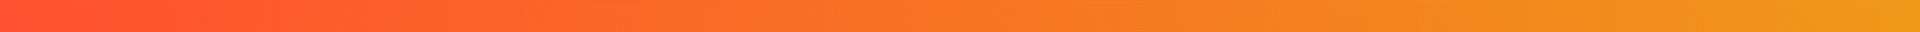

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import roc_auc_score

from category_encoders import OrdinalEncoder

from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection
)

%matplotlib inline

plt.style.use("dark_background")

---

# <en><center>Data Preparation</center></en>

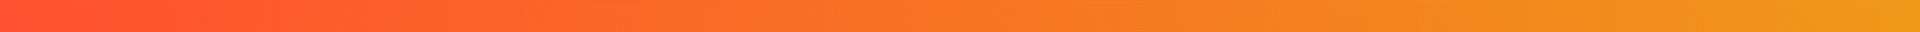

## Import Dataset

In [6]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Correct column name formatting
    df.columns = df.columns.str.strip()
    
    # Rename Target column
    df = df.rename(columns = {"Bankrupt?" : "Bankrupt"})
    
    return df

In [7]:
data = wrangle("data.csv")

In [8]:
df = data.copy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt                                                 6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

<blockquote> There are no missing values in the dataset.</blockquote>

In [1]:
df.describe()

NameError: name 'df' is not defined

---

## Dataset Exploration

Checking the percentage of the Majority and Minority Classes

In [11]:
df["Bankrupt"].value_counts(normalize = True)

Bankrupt
0    0.967737
1    0.032263
Name: proportion, dtype: float64

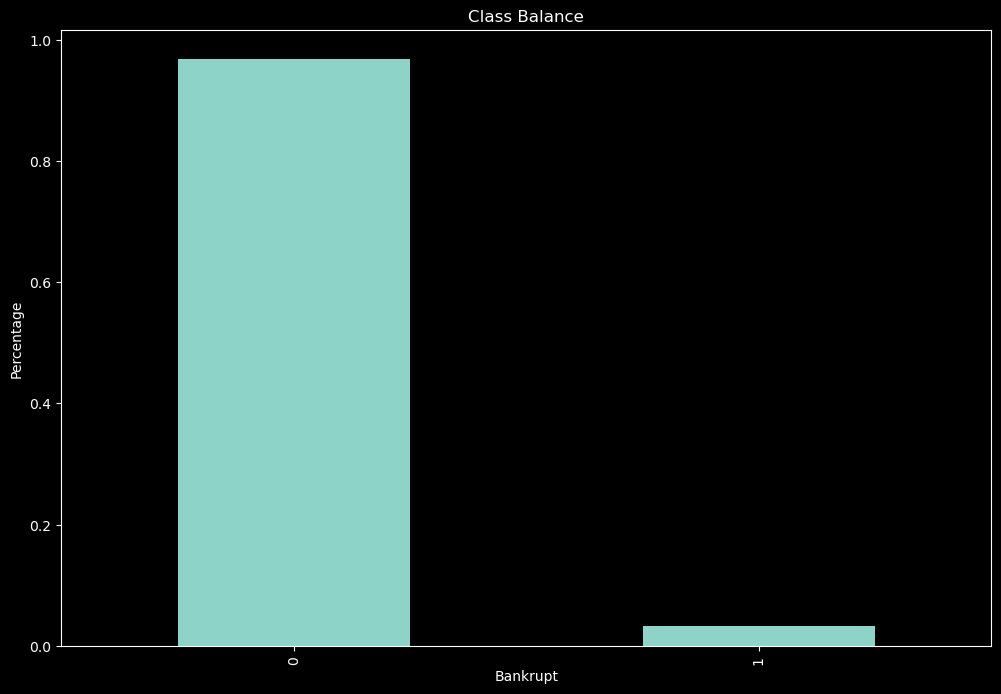

In [12]:
fig, ax = plt.subplots(figsize = (12, 8))

df["Bankrupt"].value_counts(normalize = True).plot(kind = "bar")

plt.xlabel("Bankrupt")
plt.ylabel("Percentage")
plt.title("Class Balance");

<blockquote> The Majority Class is the class with the highest frequency.
    <br>In this case, it is represented as 0. 
    <br>Which is also refering to the companies that did not go bankrupt.
    <br>The Minority Class is the class with the fewest frequency.
    <br>In this case the minority class is represented as 1.
    <br>This is also refering to the companies that experienced bankruptcy.
</blockquote>

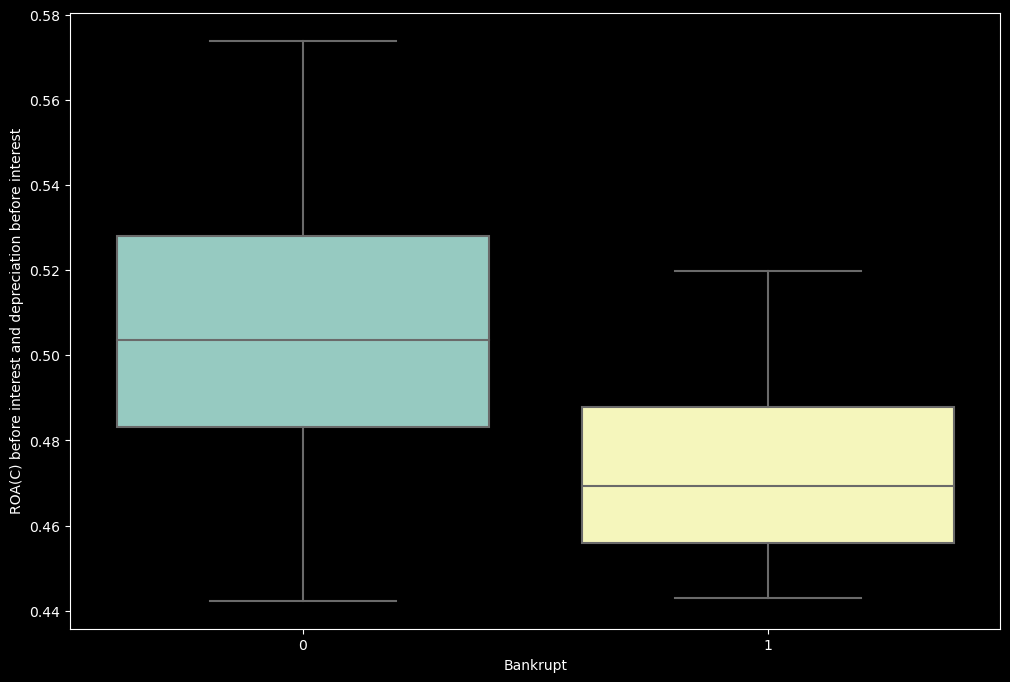

In [13]:
fig, ax = plt.subplots(figsize = (12, 8))


low, high = df["ROA(C) before interest and depreciation before interest"].quantile([0.1, 0.9])
mask = df["ROA(C) before interest and depreciation before interest"].between(low, high)
sns.boxplot(
    data = df[mask],
    x = "Bankrupt",
    y = "ROA(C) before interest and depreciation before interest"
);

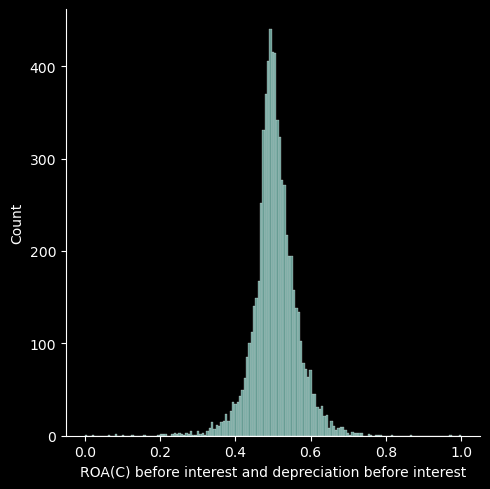

In [14]:
sns.displot(
    data = df,
    x = df["ROA(C) before interest and depreciation before interest"]
)
plt.xlabel("ROA (C)")
plt.ylabel("Frequency")
plt.title("ROA (C) Distribution");

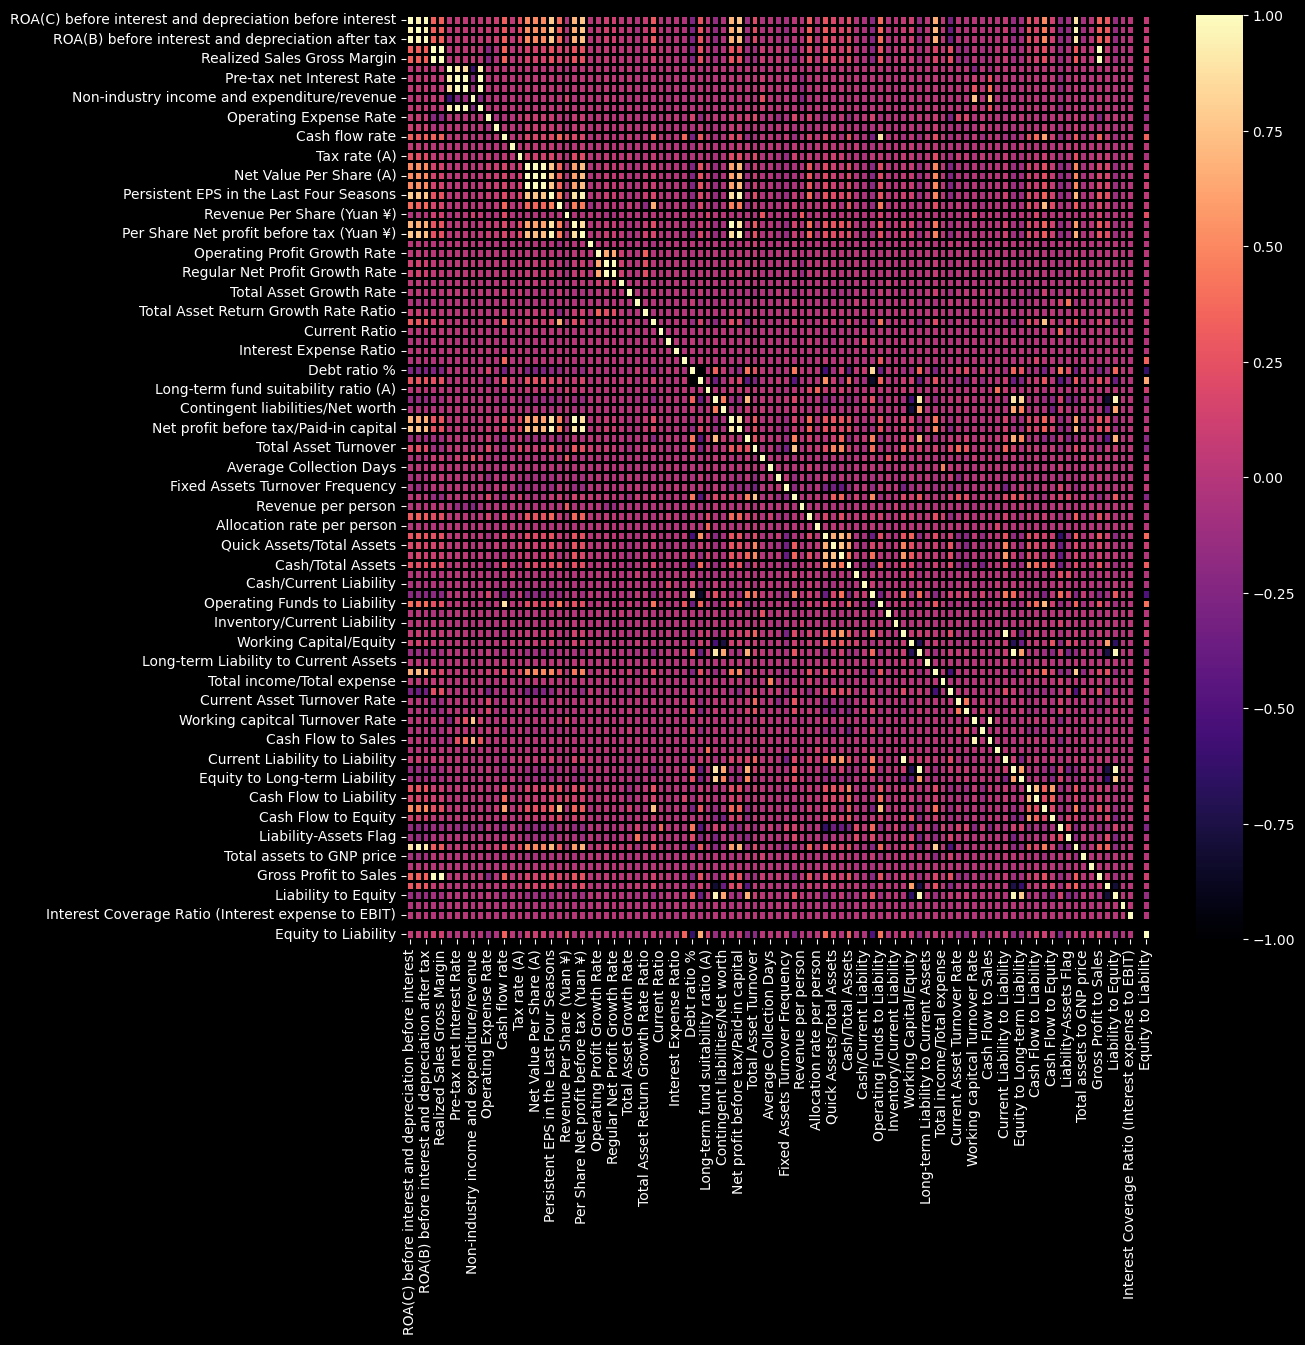

In [15]:
corr = df.drop(columns = "Bankrupt").corr()
 
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(
    corr,
    cmap = "magma",
    linecolor = "black",
    linewidth = 1)
plt.title()
;

## Train-Test Split

In [16]:
target = "Bankrupt"
X = df.drop(columns = target, axis = 1)
y = df[target]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6819, 95)
Shape of y: (6819,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3,
    random_state = 42
)

In [27]:
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=42,
    n_jobs=4,
)

In [28]:
pipe = Pipeline([
    ("constant", DropConstantFeatures(tol = 0.998)),
    ("duplicated", DropDuplicateFeatures()),
    ("correlation", SmartCorrelatedSelection(
        variables = None,
        method = "pearson",
        threshold = 0.8,
        selection_method="model_performance",
        estimator = rf,
        scoring = "roc_auc",
        cv = 3
    )
    )
])

In [30]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlation',
                 SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=10,
                                                                           n_jobs=4,
                                                                           random_state=20),
                                          selection_method='model_performance'))])

In [31]:
pipe["constant"].features_to_drop_

['Liability-Assets Flag', 'Net Income Flag']

In [32]:
pipe["duplicated"].features_to_drop_

{'Current Liability to Equity', 'Current Liability to Liability'}

In [33]:
pipe["correlation"].features_to_drop_

['ROA(C) before interest and depreciation before interest',
 'ROA(B) before interest and depreciation after tax',
 'Operating Gross Margin',
 'Operating Profit Rate',
 'After-tax net Interest Rate',
 'Continuous interest rate (after tax)',
 'Cash flow rate',
 'Net Value Per Share (A)',
 'Net Value Per Share (C)',
 'Operating Profit Per Share (Yuan ¥)',
 'Per Share Net profit before tax (Yuan ¥)',
 'Regular Net Profit Growth Rate',
 'Net worth/Assets',
 'Borrowing dependency',
 'Operating profit/Paid-in capital',
 'Net profit before tax/Paid-in capital',
 'Quick Assets/Current Liability',
 'Current Liability to Assets',
 'Current Liabilities/Equity',
 'Working capitcal Turnover Rate',
 'Cash Flow to Sales',
 'Net Income to Total Assets',
 'Gross Profit to Sales',
 'Liability to Equity']

In [34]:
pipe["correlation"].correlated_feature_sets_

[{'Net Income to Total Assets',
  'ROA(A) before interest and % after tax',
  'ROA(B) before interest and depreciation after tax',
  'ROA(C) before interest and depreciation before interest'},
 {'Gross Profit to Sales',
  'Operating Gross Margin',
  'Realized Sales Gross Margin'},
 {'After-tax net Interest Rate',
  'Cash Flow to Sales',
  'Continuous interest rate (after tax)',
  'Operating Profit Rate',
  'Pre-tax net Interest Rate',
  'Working capitcal Turnover Rate'},
 {'Cash flow rate', 'Operating Funds to Liability'},
 {'Net Value Per Share (A)',
  'Net Value Per Share (B)',
  'Net Value Per Share (C)'},
 {'Net profit before tax/Paid-in capital',
  'Operating Profit Per Share (Yuan ¥)',
  'Operating profit/Paid-in capital',
  'Per Share Net profit before tax (Yuan ¥)',
  'Persistent EPS in the Last Four Seasons'},
 {'After-tax Net Profit Growth Rate', 'Regular Net Profit Growth Rate'},
 {'Net Value Growth Rate', 'Quick Assets/Current Liability'},
 {'Current Liability to Assets', '

In [ ]:
X_train = 